In [2]:
.libPaths('/root/miniconda3/envs/Rdoc/lib/R/library')

In [7]:
library(scran)

In [4]:
library(SpatialExperiment)

In [16]:
T = readRDS('./T.rds')

In [17]:
assay(T, "exprs") <- asinh(counts(T)/1)

In [73]:
biggene = c('CD14','FAP','Vimentin','HLA-DR',
           'CD68','CD20')

In [74]:
allgene = rownames(T)

In [75]:
biggene

[1] "CD14"     "FAP"      "Vimentin" "HLA-DR"   "CD68"     "CD20"

In [76]:
funcge = setdiff(allgene,biggene)

In [95]:
funcge

[1] "IL-6"      "FoxP3"     "CD69"      "CD4"       "CD8a"      "CollagenI"
 [7] "BCA1"      "CD31"      "TIM3"      "PDPN"      "CD103"     "CD276"    
[13] "CD71"      "CXCR4"     "PD-L1"     "CCR7"      "CD11b"     "FosB"     
[19] "GranzymeB" "PD-1"      "Ki-67"     "GATA-3"    "CD45RA"    "CD3"      
[25] "TNFa"      "m6A"       "CD45RO"    "CD57"      "OLR1"      "KLF2"     
[31] "NLRP3"     "HIF1a"

In [97]:
funcge = c('FoxP3','CD69','CD4','CD8a','CD103','PD-L1','CCR7','GranzymeB','PD-1','Ki-67','GATA-3','CD45RA','CD3','TNFa','CD45RO','CD57')

In [98]:
library(batchelor)
set.seed(220228)
out <- fastMNN(T, batch = T$sample_id,
               auto.merge = TRUE,
               subset.row = funcge,
               assay.type = "exprs")

# Check that order of cells is the same
stopifnot(all.equal(colnames(T), colnames(out)))

# Transfer the correction results to the main spe object
reducedDim(T, "fastMNN") <- reducedDim(out, "corrected")

Warning message in check_numbers(k = k, nu = nu, nv = nv, limit = min(dim(x)) - :
“more singular values/vectors requested than available”
Warning message in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE, :
“You're computing too large a percentage of total singular values, use a standard svd instead.”


In [99]:
merge_info <- metadata(out)$merge.info 
merge_info[,c("left", "right", "batch.size")]

DataFrame with 60 rows and 3 columns
                                       left       right batch.size
                                     <List>      <List>  <numeric>
1                               T005_ROI007 T005_ROI001   0.187525
2                   T005_ROI007,T005_ROI001 T005_ROI005   0.278521
3       T005_ROI007,T005_ROI001,T005_ROI005 T005_ROI006   0.233713
4   T005_ROI007,T005_ROI001,T005_ROI005,... T005_ROI011   0.201556
5   T005_ROI007,T005_ROI001,T005_ROI005,... T005_ROI003   0.458130
...                                     ...         ...        ...
56  T005_ROI007,T005_ROI001,T005_ROI005,... T002_ROI012   0.987844
57  T005_ROI007,T005_ROI001,T005_ROI005,... T002_ROI008   0.991655
58  T005_ROI007,T005_ROI001,T005_ROI005,... T001_ROI010   0.992651
59  T005_ROI007,T005_ROI001,T005_ROI005,... T001_ROI006   0.988587
60  T005_ROI007,T005_ROI001,T005_ROI005,... T002_ROI011   0.986270

In [100]:
spe =T

In [101]:
library(scater)
set.seed(220228)
spe <- runUMAP(T, dimred= "fastMNN", name = "UMAP_mnnCorrected") 

In [102]:
library(Rphenograph)
library(igraph)
library(dittoSeq)

In [103]:
mat <- t(assay(T, "exprs")[funcge,])
set.seed(230619)
# out <- Rphenograph(mat, k = 25)
# clusters <- factor(membership(out[[2]]))
# spe$pg_clusters_corrected <- clusters

In [104]:
# dittoDimPlot(spe, var = "pg_clusters_corrected", 
#              reduction.use = "UMAP_mnnCorrected", size = 0.2,
#              do.label = TRUE) +
#     ggtitle("Phenograph clusters on UMAP, integrated cells")

###  bluster

In [105]:
library(bluster)
library(BiocParallel)
library(ggplot2)

mat <- t(assay(spe, "exprs")[funcge,])

In [106]:
spe

class: SpatialExperiment 
dim: 38 39082 
metadata(0):
assays(2): counts exprs
rownames(38): IL-6 CD14 ... HIF1a Vimentin
rowData names(0):
colnames(39082): T001_ROI001.9 T001_ROI001.13 ... T005_ROI012.3206
  T005_ROI012.3207
colData names(8): AreaID CellID ... patient_id celltype
reducedDimNames(2): fastMNN UMAP_mnnCorrected
mainExpName: NULL
altExpNames(0):
spatialCoords names(2) : Pos_X Pos_Y
imgData names(1): sample_id

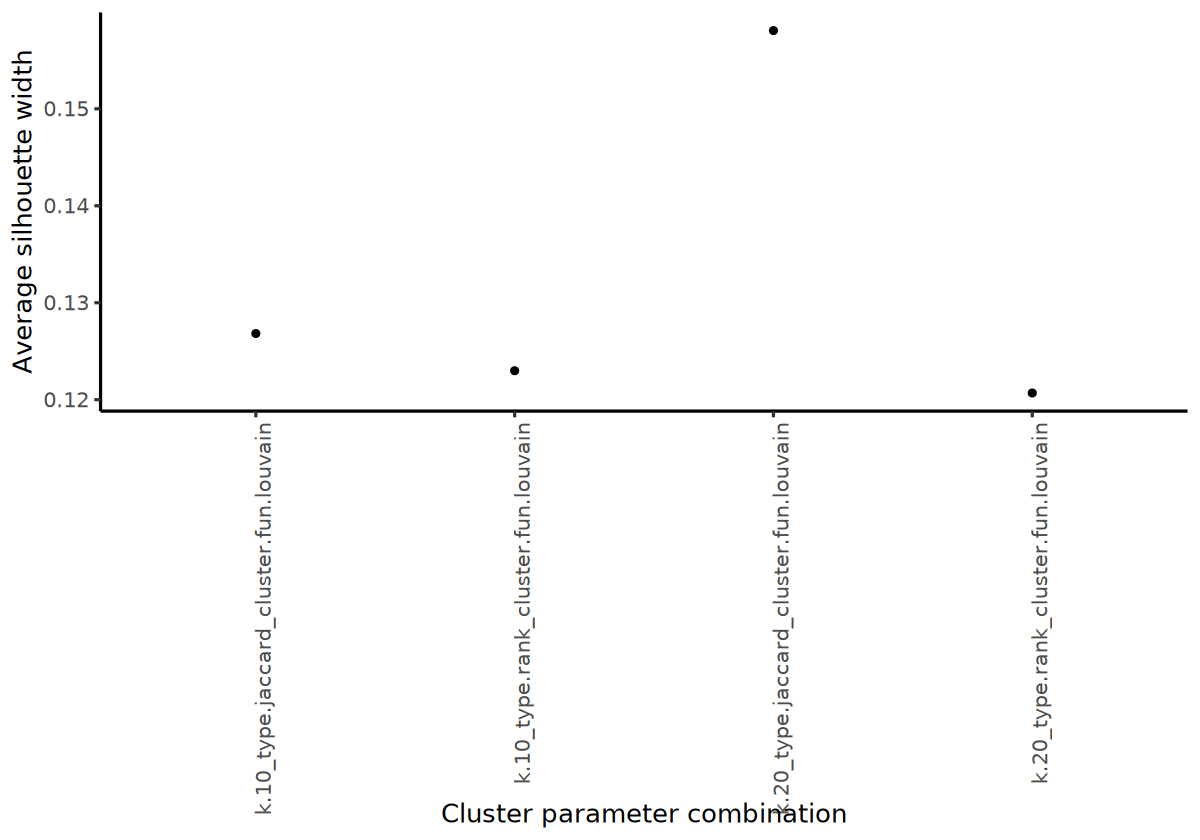

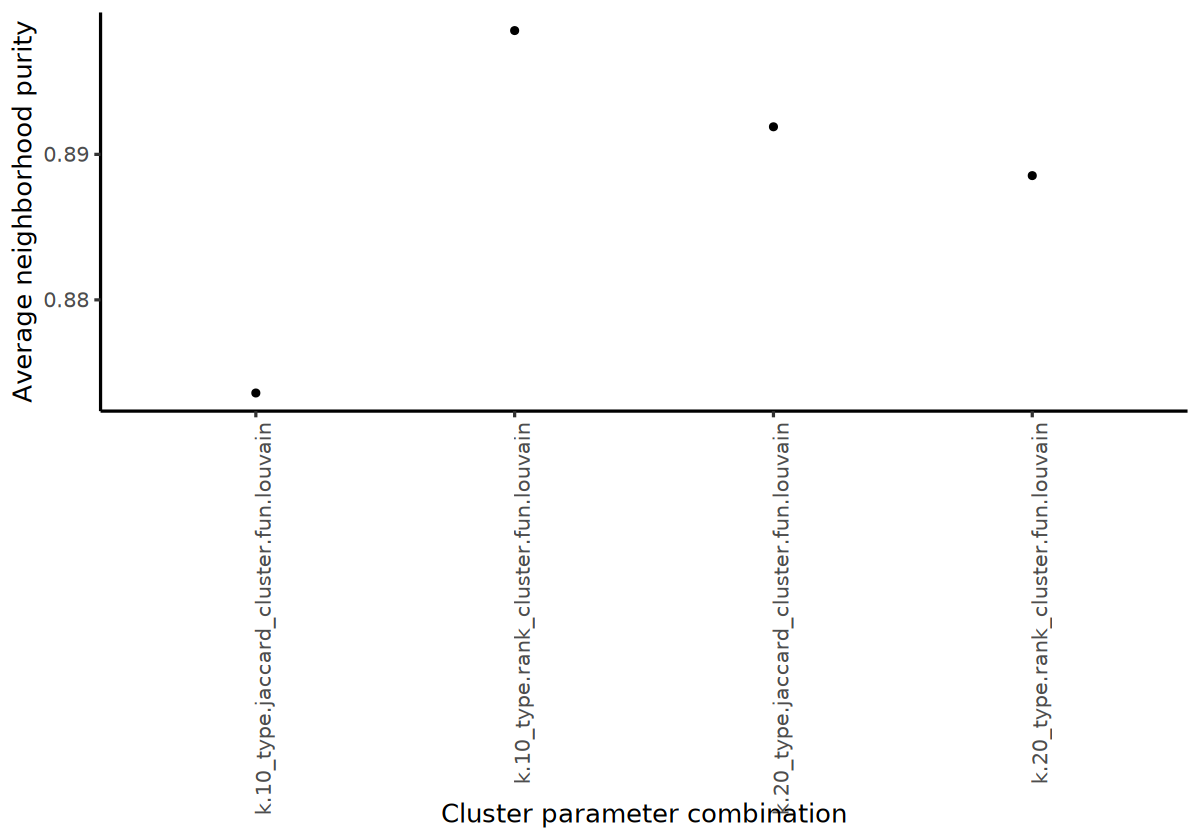

In [107]:
combinations <- clusterSweep(mat, 
                             BLUSPARAM=SNNGraphParam(),
                             k=c(10L, 20L), 
                             type = c("rank", "jaccard"), 
                             cluster.fun = "louvain",
                             BPPARAM = MulticoreParam(RNGseed = 220427))

sil <- vapply(as.list(combinations$clusters), 
              function(x) mean(approxSilhouette(mat, x)$width), 
              0)

ggplot(data.frame(method = names(sil),
                  sil = sil)) +
    geom_point(aes(method, sil)) +
    theme_classic(base_size = 15) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    xlab("Cluster parameter combination") +
    ylab("Average silhouette width")

pur <- vapply(as.list(combinations$clusters), 
              function(x) mean(neighborPurity(mat, x)$purity), 
              0)

ggplot(data.frame(method = names(pur),
                  pur = pur)) +
    geom_point(aes(method, pur)) +
    theme_classic(base_size = 15) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    xlab("Cluster parameter combination") +
    ylab("Average neighborhood purity")

set.seed(220621)
clusters <- clusterCells(spe, 
                         use.dimred = "fastMNN", 
                         BLUSPARAM = SNNGraphParam(k = 20, 
                                        cluster.fun = "louvain",
                                        type = "rank"))

spe$nn_clusters_corrected <- clusters

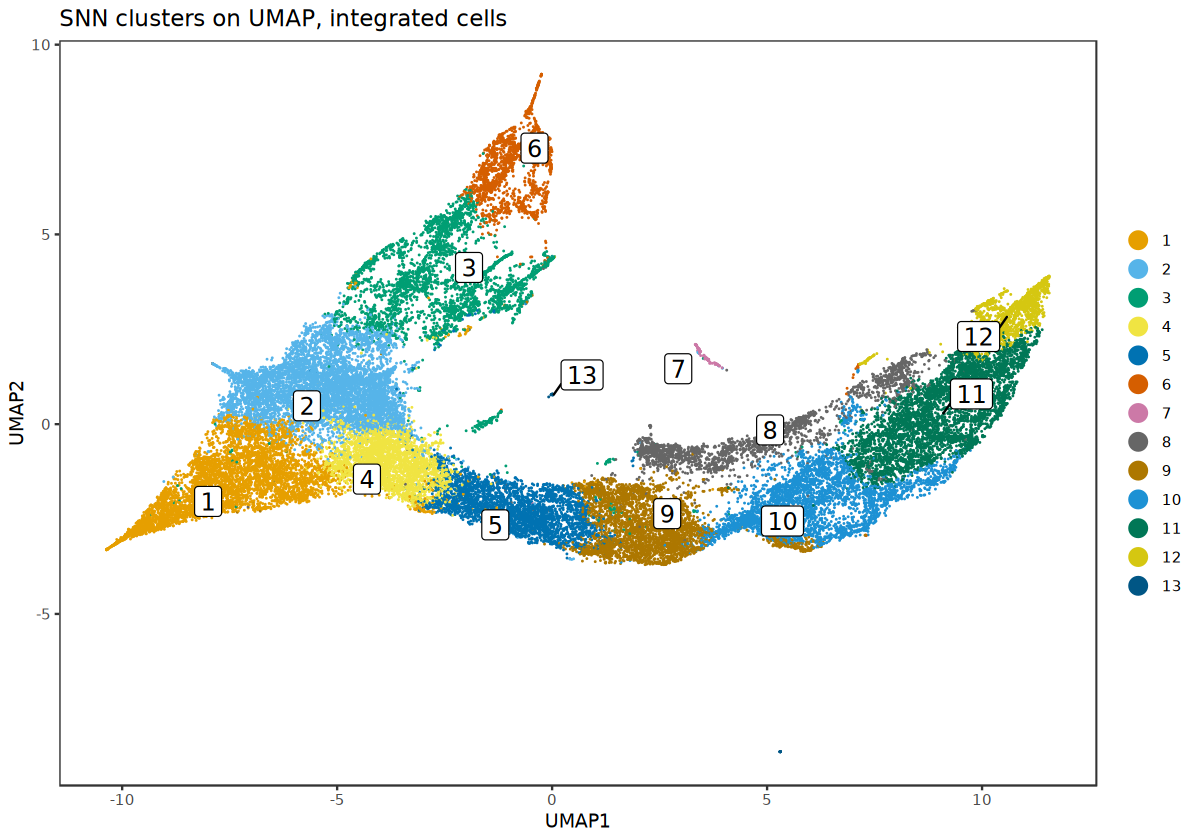

In [108]:
dittoDimPlot(spe, var = "nn_clusters_corrected", 
             reduction.use = "UMAP_mnnCorrected", size = 0.2,
             do.label = TRUE) +
    ggtitle("SNN clusters on UMAP, integrated cells")

In [109]:
library(stringr)

In [110]:
spe$ROI <- str_sub(spe$sample_id, -3, -1)
spe$patient_id <- str_extract(spe$sample_id, "T00[1-5]")

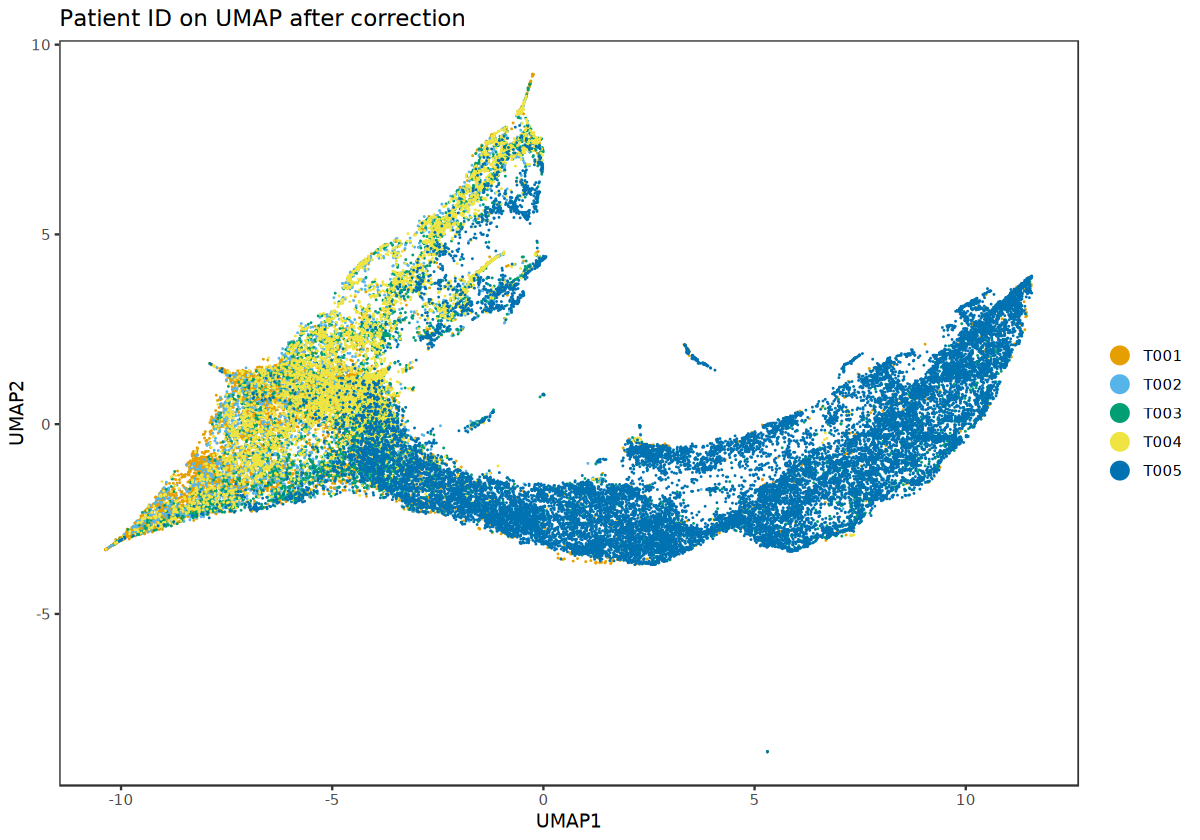

In [111]:
library(cowplot)
library(dittoSeq)
library(viridis)
dittoDimPlot(spe, var = "patient_id", 
                   reduction.use = "UMAP_mnnCorrected", size = 0.2) + 
   #scale_color_manual(values = metadata(spe)$color_vectors$patient_id) +
    ggtitle("Patient ID on UMAP after correction")

In [112]:
library(scuttle)

## aggregate by cell type
celltype_mean <- aggregateAcrossCells(as(spe, "SingleCellExperiment"),  
                     ids = spe$nn_clusters_corrected, 
                     statistics = "mean",
                     use.assay.type = "exprs", 
                     subset.row =funcge )

library(dittoSeq)
library(colorspace)
library(viridis)

options(repr.plot.width = 10)



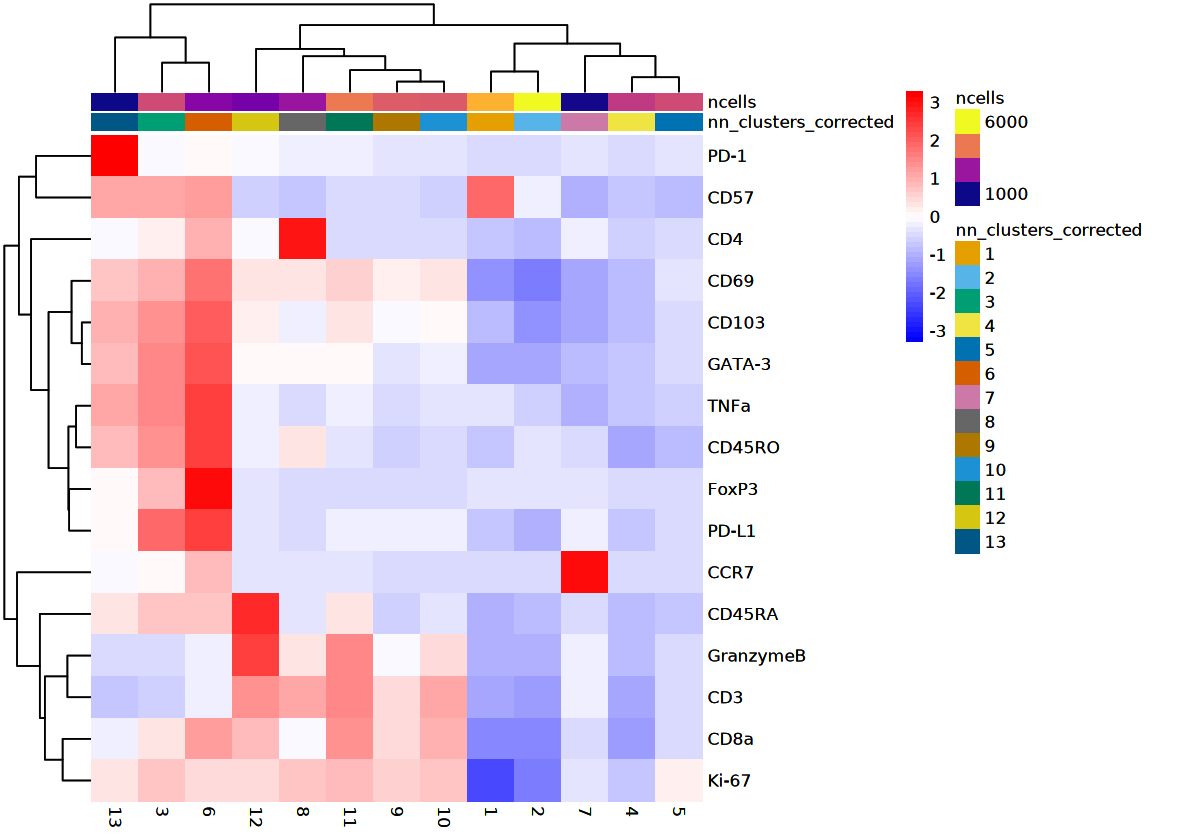

In [113]:
dittoHeatmap(celltype_mean,
             assay = "exprs", 
             cluster_cols = TRUE, show_rownames = TRUE,show_colnames =TRUE,
             annot.by = c("nn_clusters_corrected", "ncells"),
             annotation_colors = list(celltype = metadata(spe)$color_vectors$nn_clusters_corrected,
                                      ncells = plasma(100)))

In [115]:
library(dplyr)
cluster_celltype <- recode(spe$nn_clusters_corrected,
                            '1' = 'NK_CD57',
                           '2' = 'unlabel',
                            '6' = 'Tregs_FoxP3',
                           '3' ='Tregs_FoxP3',
                           '13' ='Tcell_PD1',
                           '12' = 'TCL_CD8A_GRZB',   
                            '11' = 'TCL_CD8A_GRZB',
                           '8' = 'Prolif_CD4_KI67',
                           '9' = 'Prolif_CD8_KI67',
                           '10' = 'Prolif_CD8_KI67',
                           '7' = 'Tcell_naive',
                           '4' = 'unlabel',
                           '5' = 'unlabel'
                                    
)

In [116]:
spe$celltype <- cluster_celltype

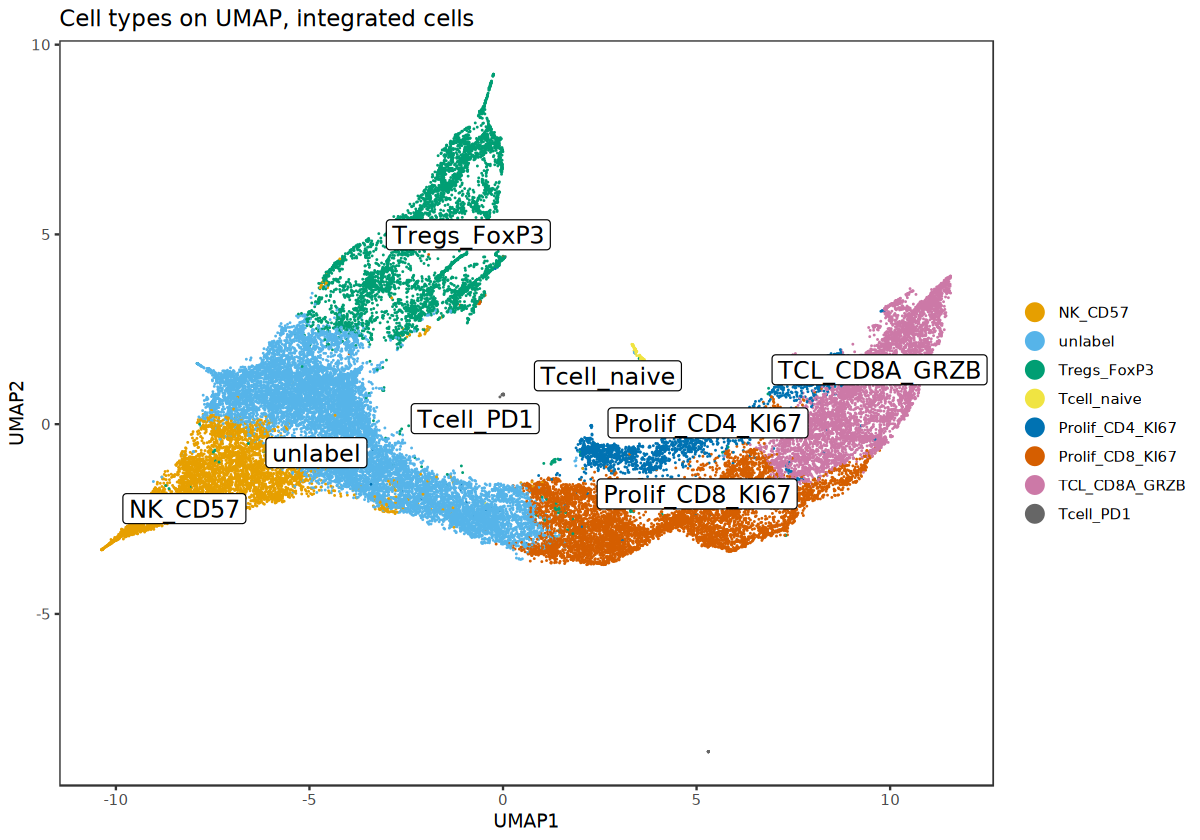

In [117]:
dittoDimPlot(spe, 
                   var = "celltype", 
                   reduction.use = "UMAP_mnnCorrected", 
                   size = 0.2,
                   do.label = TRUE) +
 # scale_color_manual(values = metadata(spe)$color_vectors$celltype) +
  theme(legend.title = element_blank()) +
  ggtitle("Cell types on UMAP, integrated cells")

In [118]:
unique(spe$celltype)

[1] NK_CD57         unlabel         Tregs_FoxP3     Tcell_naive    
[5] Prolif_CD4_KI67 Prolif_CD8_KI67 TCL_CD8A_GRZB   Tcell_PD1      
8 Levels: NK_CD57 unlabel Tregs_FoxP3 Tcell_naive ... Tcell_PD1

In [119]:
T = spe[,spe$celltype %in% c('NK_CD57','Tregs_FoxP3','Tcell_naive','Prolif_CD4_KI67','Prolif_CD8_KI67','TCL_CD8A_GRZB','Tcell_PD1')]

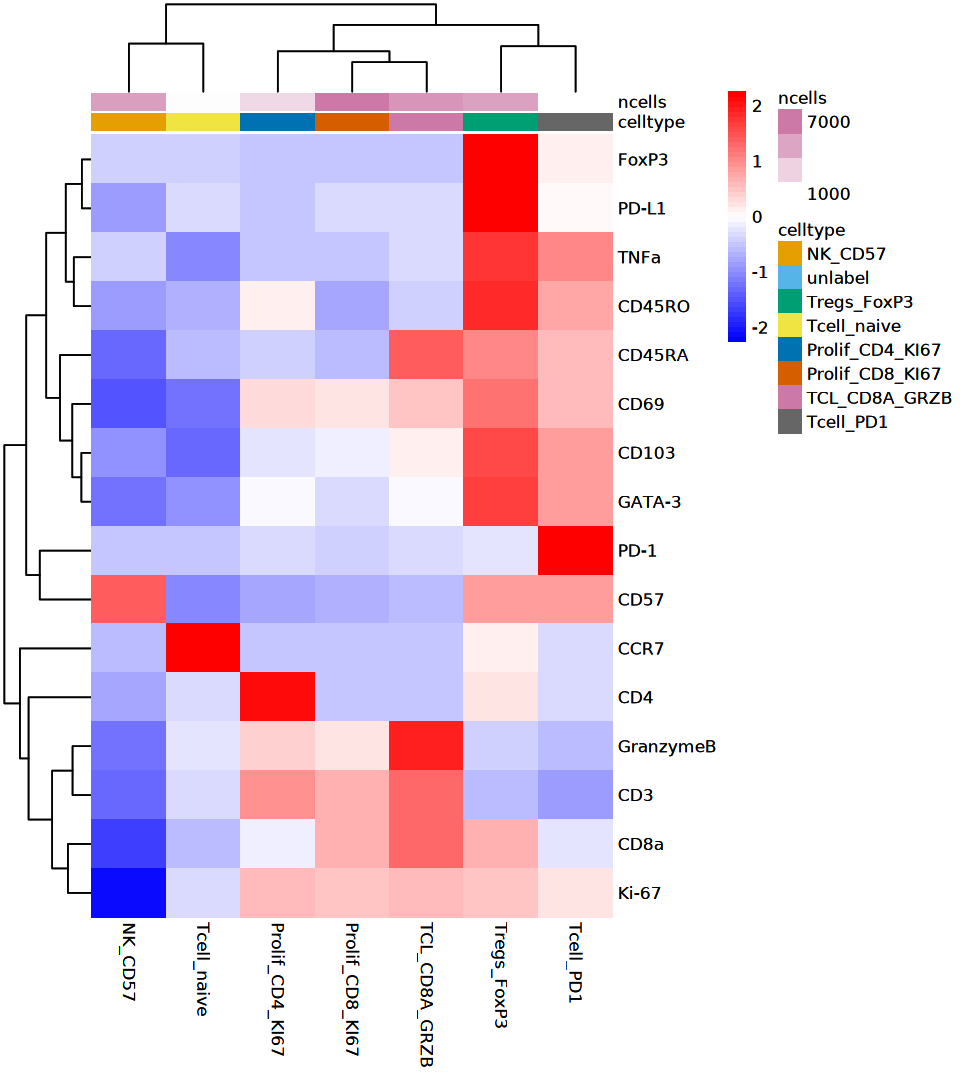

In [177]:
library(scuttle)

## aggregate by cell type
celltype_mean <- aggregateAcrossCells(as(T, "SingleCellExperiment"),  
                     ids = T$celltype, 
                     statistics = "mean",
                     use.assay.type = "exprs", 
                     subset.row = funcge)

library(dittoSeq)
library(colorspace)
library(viridis)

options(repr.plot.width = 8,repr.plot.height = 9)

dittoHeatmap(celltype_mean,
             assay = "exprs", 
             cluster_cols = TRUE, show_rownames = TRUE,show_colnames =TRUE,
             annotation_colors = pal_npg("nrc")(10),
             annot.by = c("celltype", "ncells"))

In [125]:
spe =T

In [5]:
spe = readRDS('./T.anno.rds')

In [170]:
options(repr.plot.width = 7,repr.plot.height = 6)

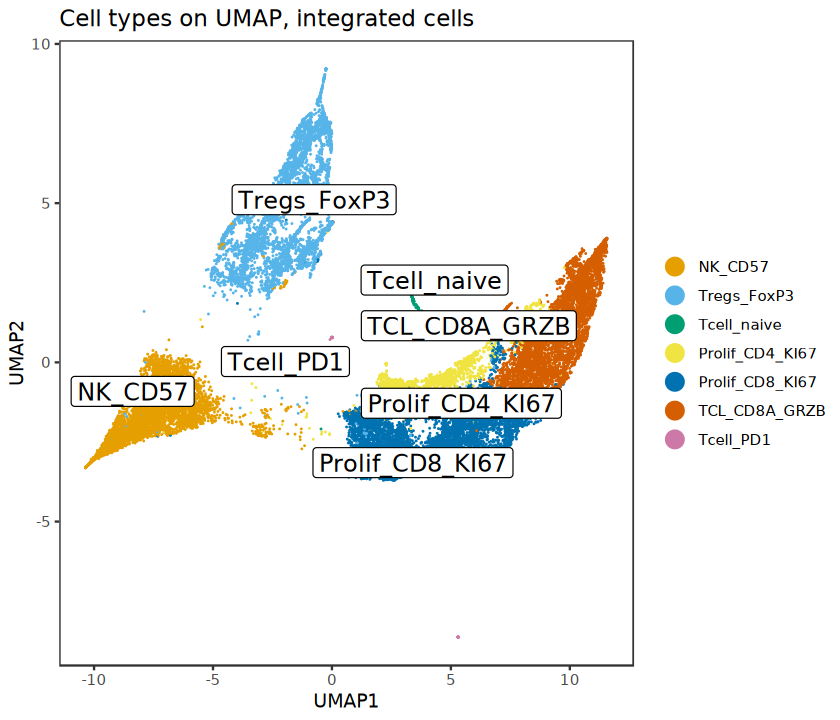

In [171]:
dittoDimPlot(spe, 
                   var = "celltype", 
                   reduction.use = "UMAP_mnnCorrected", 
                   size = 0.2,
                   do.label = TRUE) +
 # scale_color_manual(values = metadata(spe)$color_vectors$celltype) +
  theme(legend.title = element_blank()) +
  ggtitle("Cell types on UMAP, integrated cells")

In [127]:
table(spe$celltype, spe$patient_id)

                 
                  T001 T002 T003 T004 T005
  NK_CD57         2359 1226  698  848  242
  unlabel            0    0    0    0    0
  Tregs_FoxP3      245 1022 1017 1756 1166
  Tcell_naive       35    1    2    3   85
  Prolif_CD4_KI67   76   13   63   19 1989
  Prolif_CD8_KI67  166   26  556   16 6696
  TCL_CD8A_GRZB    121    0  401   11 5367
  Tcell_PD1          0    7   13    9    9

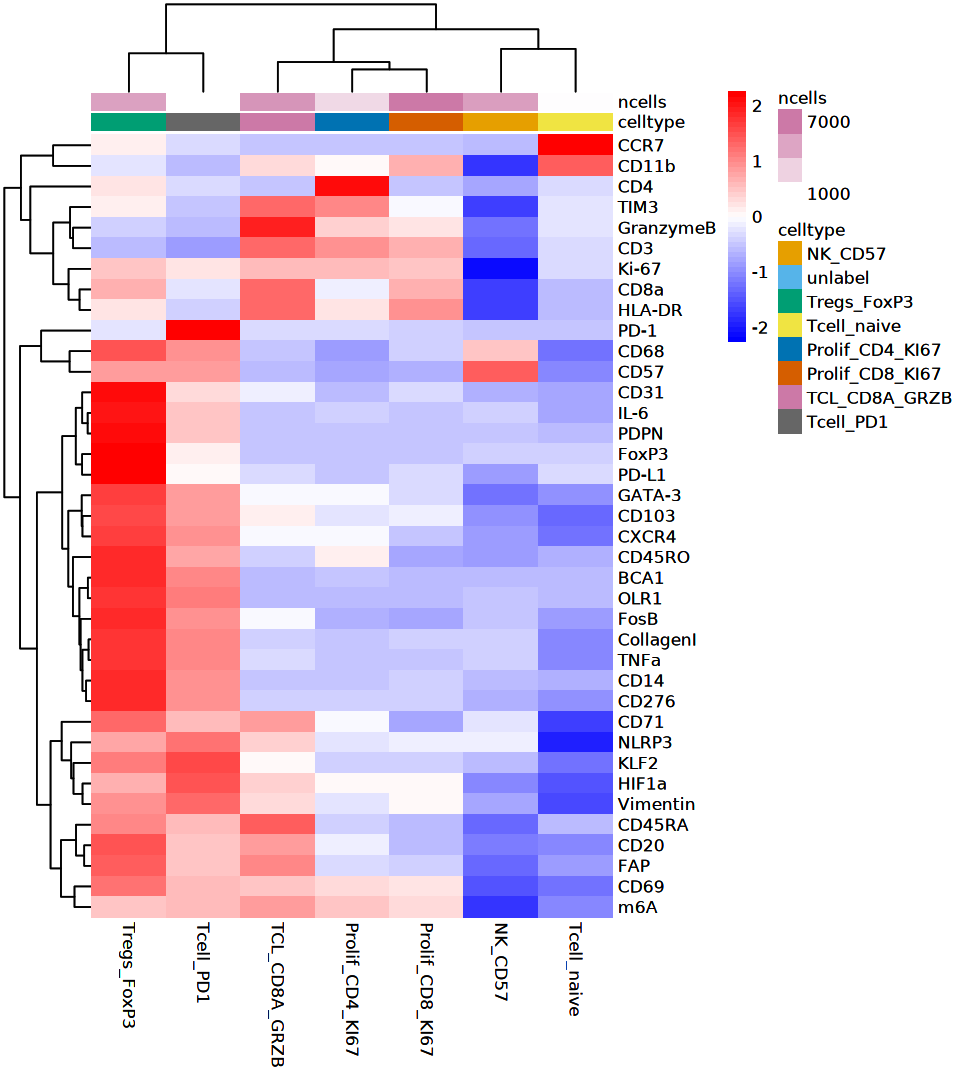

In [128]:
library(scuttle)

## aggregate by cell type
celltype_mean <- aggregateAcrossCells(as(spe, "SingleCellExperiment"),  
                     ids = spe$celltype, 
                     statistics = "mean",
                     use.assay.type = "exprs", 
                     subset.row = rownames(spe))

library(dittoSeq)
library(colorspace)
library(viridis)

options(repr.plot.width = 8,repr.plot.height = 9)

dittoHeatmap(celltype_mean,
             assay = "exprs", 
             cluster_cols = TRUE, show_rownames = TRUE,show_colnames =TRUE,
             annot.by = c("celltype", "ncells"))

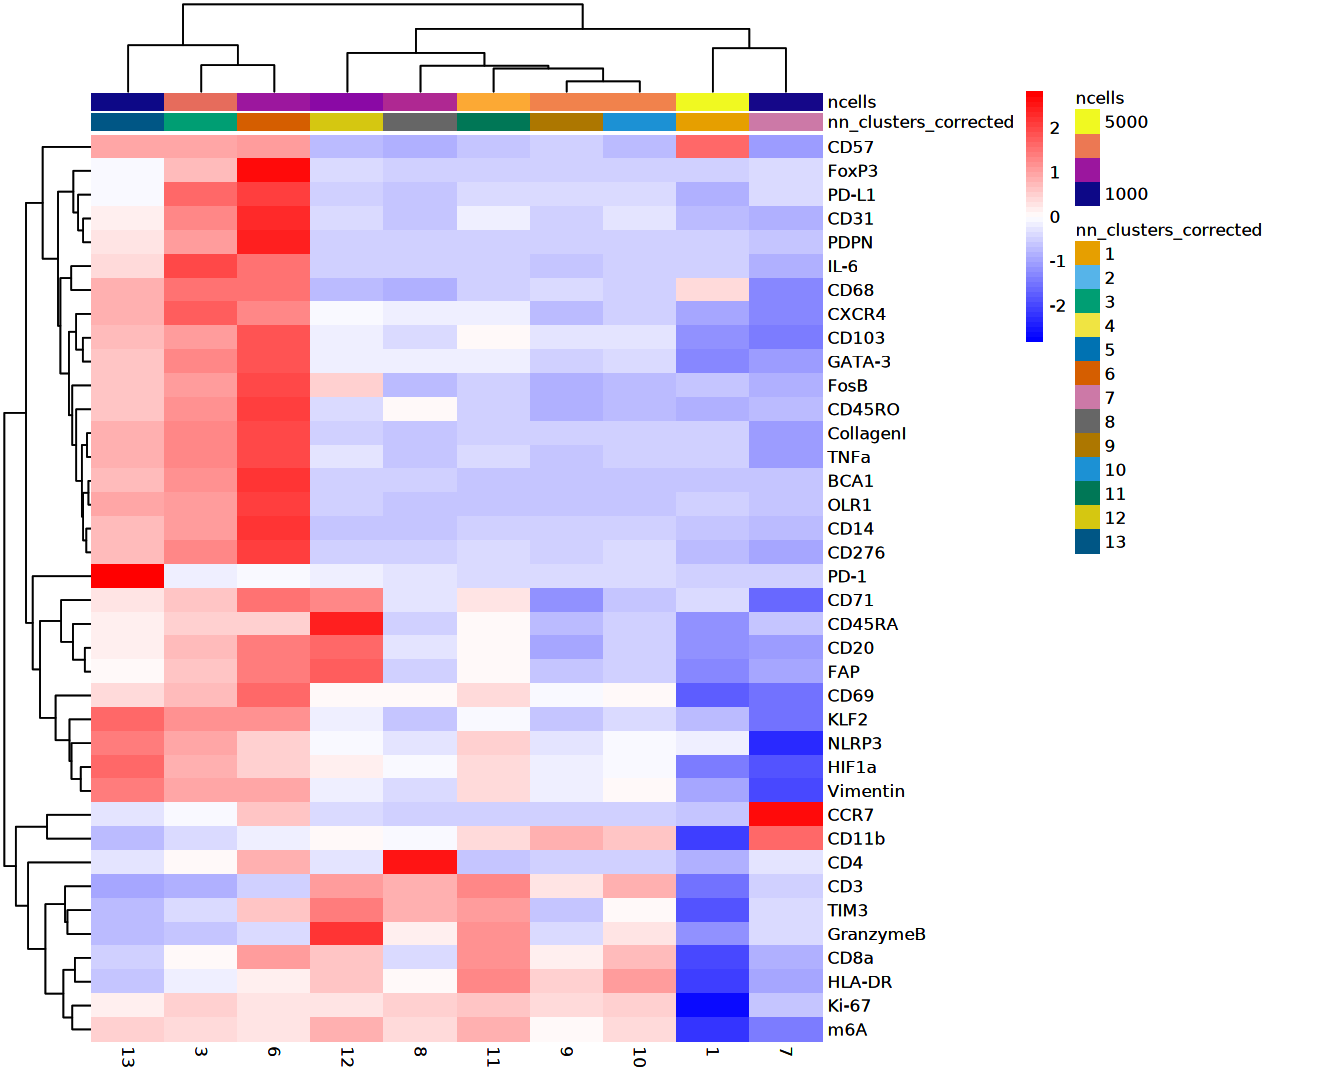

In [129]:
library(scuttle)

## aggregate by cell type
celltype_mean <- aggregateAcrossCells(as(spe, "SingleCellExperiment"),  
                     ids = spe$nn_clusters_corrected, 
                     statistics = "mean",
                     use.assay.type = "exprs", 
                     subset.row = rownames(spe))

library(dittoSeq)
library(colorspace)
library(viridis)

options(repr.plot.width = 11,repr.plot.height = 9)

dittoHeatmap(celltype_mean,
             assay = "exprs", 
             cluster_cols = TRUE, show_rownames = TRUE,show_colnames =TRUE,
             annot.by = c("nn_clusters_corrected", "ncells"),
             annotation_colors = list(celltype = metadata(spe)$color_vectors$nn_clusters_corrected,
                                      ncells = plasma(100)))

In [132]:
set.seed(220818)
cur_cells <- sample(seq_len(ncol(spe)), 4000)

plot_list <- multi_dittoDimPlot(spe[,cur_cells], var = funcge, reduction.use = "UMAP_mnnCorrected", 
                   assay = "exprs", size = 0.2, list.out = TRUE) 
plot_list <- lapply(plot_list, function(x) x + scale_color_viridis(option = "B")  )
plot_grid(plotlist = plot_list) 

In [77]:
options(repr.plot.width = 14,repr.plot.height = 9)

In [133]:
# plotExpression(spe[,cur_cells], 
#                features = biggene, ncol = 5,
#                x = "celltype", 
#                exprs_values = "exprs", 
#                colour_by = "celltype") +
#     theme(axis.text.x =  element_text(angle = 90))+
#     scale_color_manual(values = pal_npg("nrc")(10))

In [134]:
options(repr.plot.width = 5,repr.plot.height = 6)

In [136]:
library(ggsci)

In [159]:
spe

class: SpatialExperiment 
dim: 38 26263 
metadata(0):
assays(2): counts exprs
rownames(38): IL-6 CD14 ... HIF1a Vimentin
rowData names(0):
colnames(26263): T001_ROI001.9 T001_ROI001.16 ... T005_ROI012.3204
  T005_ROI012.3206
colData names(8): AreaID CellID ... patient_id celltype
reducedDimNames(2): fastMNN UMAP_mnnCorrected
mainExpName: NULL
altExpNames(0):
spatialCoords names(2) : Pos_X Pos_Y
imgData names(1): sample_id

In [174]:
spe1 =  spe[,spe$sample_id %in% c(unique(spe$sample_id)[1:37],unique(spe$sample_id)[c(38,39,40,44,47)],unique(spe$sample_id)[50:61])]

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


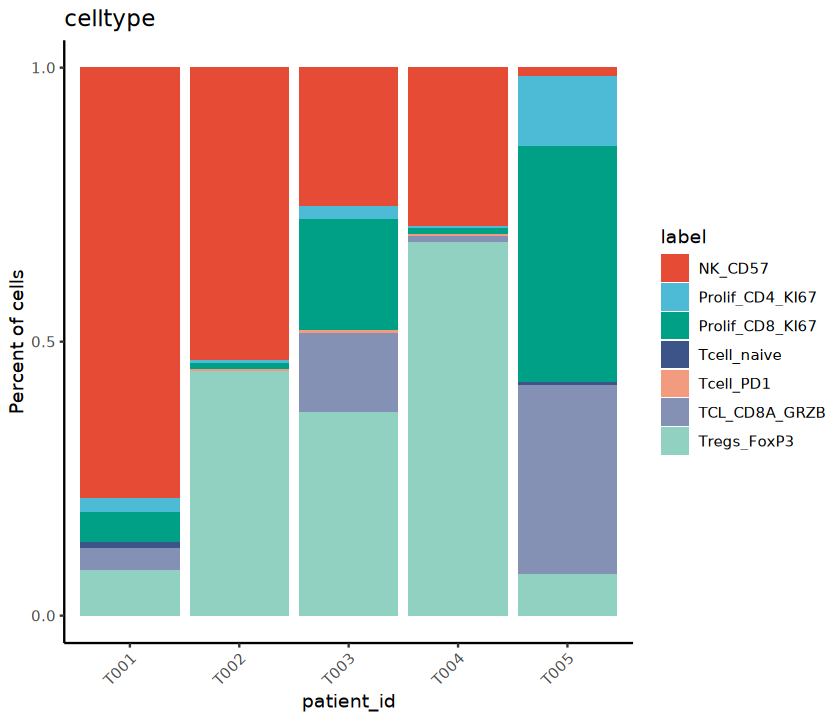

In [175]:
dittoBarPlot(spe1, 
             var = "celltype", 
             group.by = "patient_id") +
    scale_fill_manual(values = pal_npg("nrc")(10))

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


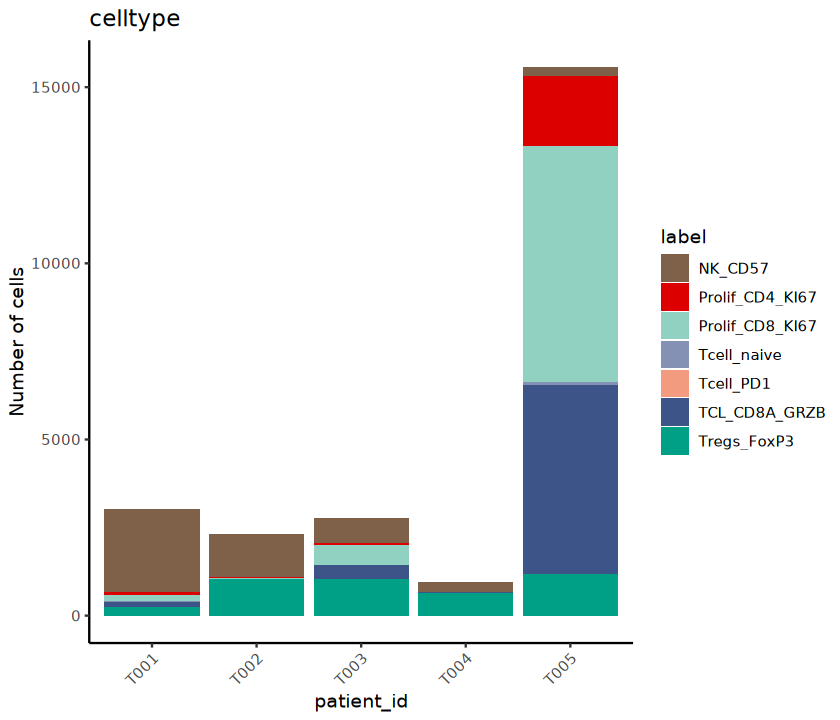

In [176]:
dittoBarPlot(spe1, 
             scale = "count",
             var = "celltype", 
             group.by = "patient_id") +
    scale_fill_manual(values = rev(pal_npg("nrc")(9)))

In [163]:
spe

class: SpatialExperiment 
dim: 38 26263 
metadata(0):
assays(2): counts exprs
rownames(38): IL-6 CD14 ... HIF1a Vimentin
rowData names(0):
colnames(26263): T001_ROI001.9 T001_ROI001.16 ... T005_ROI012.3204
  T005_ROI012.3206
colData names(8): AreaID CellID ... patient_id celltype
reducedDimNames(2): fastMNN UMAP_mnnCorrected
mainExpName: NULL
altExpNames(0):
spatialCoords names(2) : Pos_X Pos_Y
imgData names(1): sample_id

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


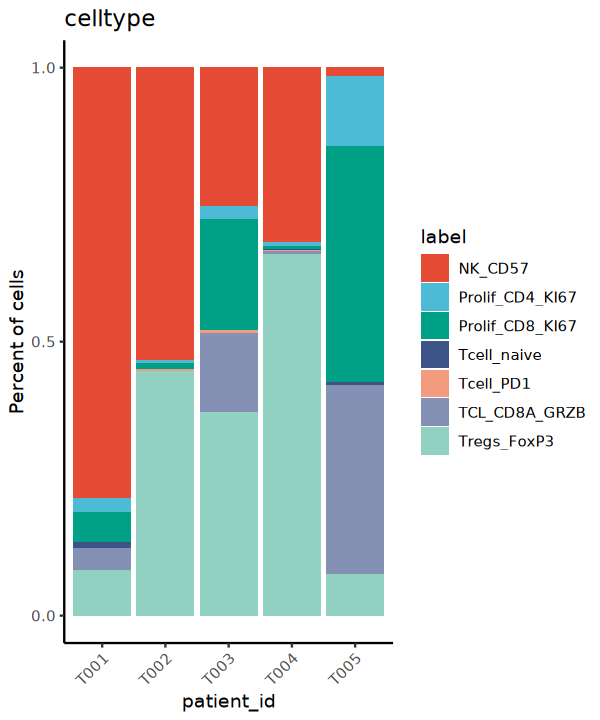

In [137]:
dittoBarPlot(spe, 
             var = "celltype", 
             group.by = "patient_id") +
    scale_fill_manual(values = pal_npg("nrc")(10))

In [140]:
library(CATALYST)

In [145]:
spe_cat <- spe 
spe_cat$sample_id <- factor(spe$sample_id)
#spe_cat$condition <- factor(spe$indication)
spe_cat$cluster_id <- factor(spe$celltype)
# Add celltype information to metadata
metadata(spe_cat)$cluster_codes <- data.frame(celltype = factor(spe_cat$celltype))

In [147]:
funcge

[1] "FoxP3"     "CD69"      "CD4"       "CD8a"      "CD103"     "PD-L1"    
 [7] "CCR7"      "GranzymeB" "PD-1"      "Ki-67"     "GATA-3"    "CD45RA"   
[13] "CD3"       "TNFa"      "CD45RO"    "CD57"

In [150]:
options(repr.plot.width = 9,repr.plot.height = 9)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


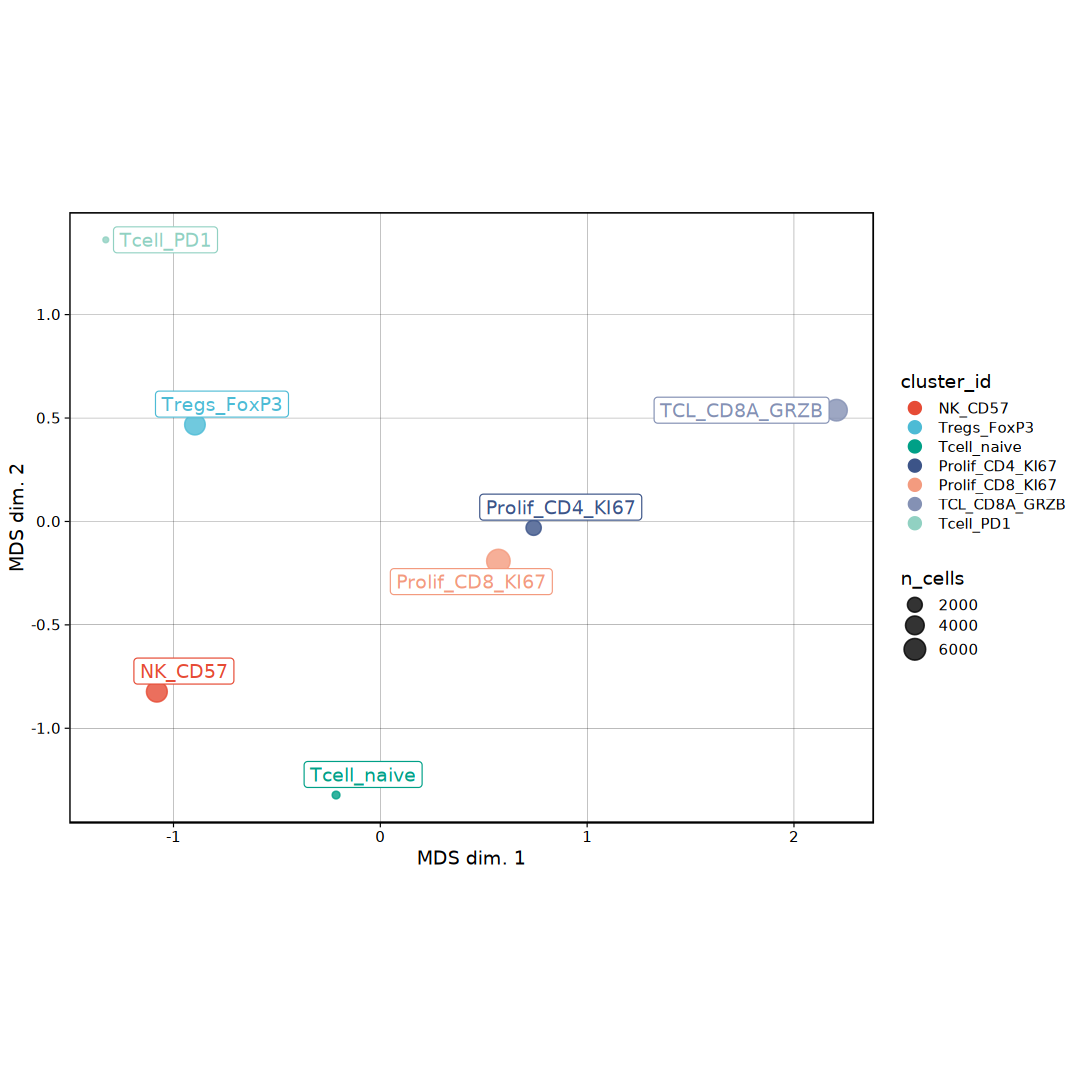

In [151]:
# MDS pseudobulk by cell type
pbMDS(spe_cat, 
      by = "cluster_id", 
      features = funcge, 
      label_by = "cluster_id", 
      k = "celltype") +
  scale_color_manual(values = pal_npg("nrc")(10))

In [166]:
saveRDS(spe,file ='T.anno.rds')